In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 1000, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd.csv', encoding='cp1252')     

In [6]:
data.columns.values

array(['Name', 'Coef_a', 'Coef_b', 'Coef_c', 'Coef_d', 'A_site', 'B_site',
       'X_site', 'Spacegroup', 'Ehull', 'BulkModulus', 'Energy', 'ZPE',
       's_A', 's_B', 's_X', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [7]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup', 'Ehull','BulkModulus', 'Energy','s_A','s_B','s_X','Coef_a','Coef_b', 'Coef_c', 'ZPE'], axis=1, inplace = True)

In [8]:
data.fillna(0, inplace= True)
#sg_dummies = pd.get_dummies(data.Spacegroup)
#d = pd.concat([data, sg_dummies], axis=1)
#d.drop(['Spacegroup'], axis=1, inplace=True)

In [9]:
d=data.copy()
d.columns.values

array(['Coef_d', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [10]:
columns = list(d.columns.values)

# Standard Scaling

In [11]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data['Coef_d']).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data['Coef_d']).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std['Coef_d'] 
X = data_std.drop(['Coef_d'], axis=1)

In [12]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [13]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'X_M', 'A_BP', 'X_B', 'X_Ra', 'X_MP', 'X_Rc', 'X_CvM', 'A_M', 'A_MendeleevNo', 'A_Rc', 'A_Ra', 'B_M', 'A_Hf', 'X_Hv', 'B_Hv', 'X_IEII', 'X_MendeleevNo', 'X_ChiA', 'X_Hf', 'A_MV', 'X_BP', 'B_BP', 'A_Hv'}


In [14]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape

(80, 51)

### Test-train splitting 

In [15]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('Coef_d')
X = df_train

Y_test = df_test.pop('Coef_d')
X_test = df_test

RF 0.9334505381501786
RMSE:  0.2591951345382817
RMSE unscaled:  2.786841269567131
----------------------------------------


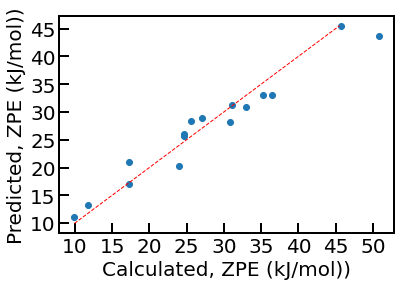

GB 0.8762852764928165
RMSE:  0.35339895862499493
RMSE unscaled:  3.7997117664750126
----------------------------------------


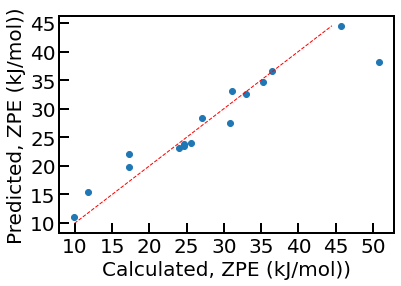

LR 0.9524950998043129
RMSE:  0.21898974404942056
RMSE unscaled:  2.354556760550349
----------------------------------------


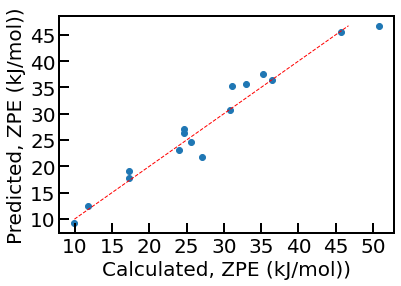

RR 0.9611918267173013
RMSE:  0.19793207218478928
RMSE unscaled:  2.128146688857087
----------------------------------------


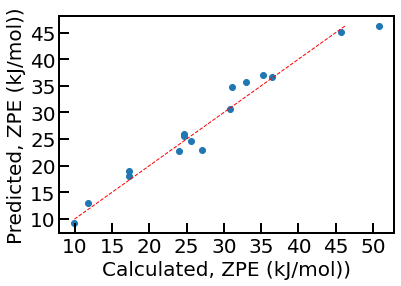

LASSO 0.9661798193346502
RMSE:  0.1847747113944695
RMSE unscaled:  1.9866800054088596
----------------------------------------


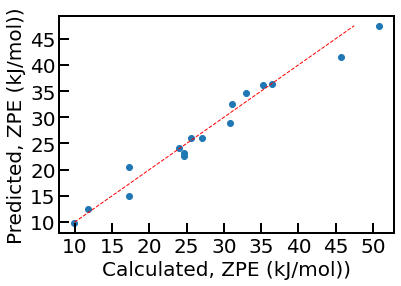

gpr1 0.9666689647680801
RMSE:  0.18343363500456952
RMSE unscaled:  1.972260880467827
----------------------------------------


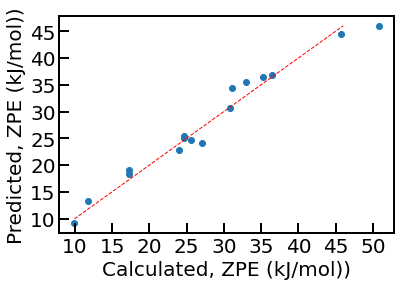

gpr2 0.9660253894925499
RMSE:  0.185196090423992
RMSE unscaled:  1.9912106323887806
----------------------------------------


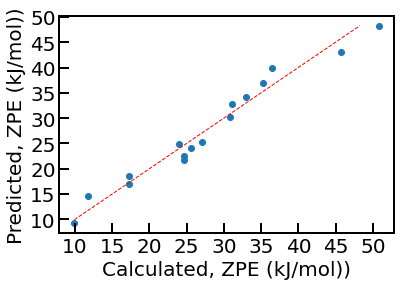

gpr3 0.9329066933940031
RMSE:  0.2602520559245182
RMSE unscaled:  2.7982051871155798
----------------------------------------


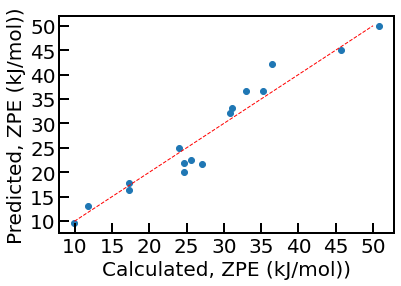

gpr4 0.9329066390743257
RMSE:  0.26025216127634526
RMSE unscaled:  2.7982063198483362
----------------------------------------


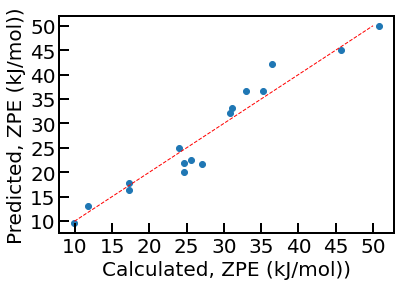

gpr5 0.6724860855795121
RMSE:  0.5750021238856309
RMSE unscaled:  6.182367781662804
----------------------------------------


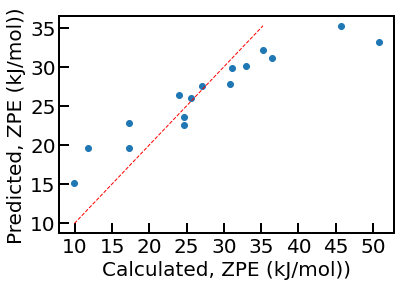

gpr6 0.8541344446005795
RMSE:  0.3837345878133891
RMSE unscaled:  4.125877546982809
----------------------------------------


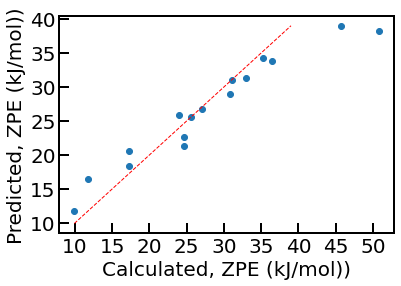

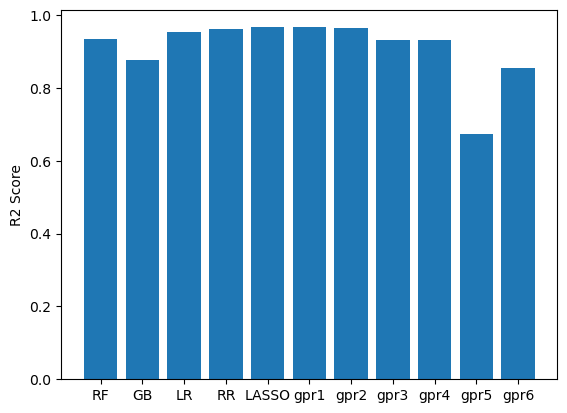

In [16]:
run_models()

In [17]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
25      X_EA  81.232938
32    X_Rvdw  69.112112
14       X_Z  43.753926
1   mean_A2B  36.476139
17       X_G  32.133586
4   mean_X2X  21.756733
30    A_Rvdw  21.351495
18     A_IEI  18.448048
13       B_Z  16.733902
41      B_Hf  16.431242
2   mean_A2X  14.661730
34      B_Ra  14.611618
7    std_B2X  14.051080
11        OF  12.789702
23      A_EA  12.359494
29    A_ChiA  12.090829
6    std_A2X  10.602250
38     B_Rho   9.731500
9      E_coh   9.463266
26    A_ChiP   9.223658
46     B_CvM   8.515155
36      B_MP   8.146515
33      B_Rc   7.662039
10        TF   6.853180
31    B_Rvdw   6.627869
35      A_MP   5.800927
8    std_X2X   5.596058
42   A_Kappa   5.555247
40      X_MV   5.384953
5    std_A2B   5.191784


In [18]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X', 'B_Ra', 'std_B2X', 'OF',
       'A_EA', 'A_ChiA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP', 'B_CvM',
       'B_MP', 'B_Rc', 'TF', 'B_Rvdw', 'A_MP', 'std_X2X', 'A_Kappa',
       'X_MV', 'std_A2B'], dtype=object)

In [19]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9355019128390618
RMSE:  0.255169045104062
RMSE unscaled:  2.743553141453776
----------------------------------------


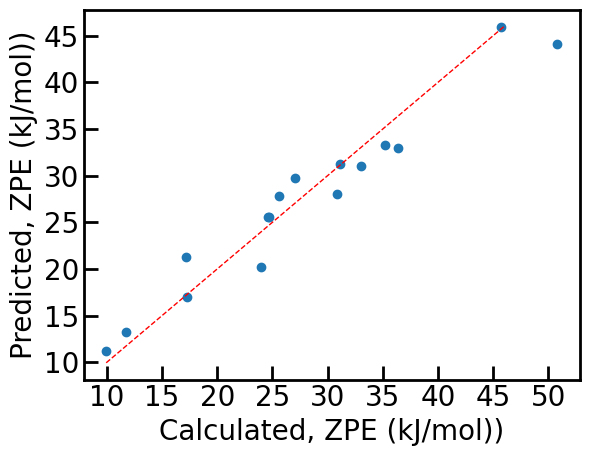

GB 0.7730825168302553
RMSE:  0.47861747358332324
RMSE unscaled:  5.1460492500910044
----------------------------------------


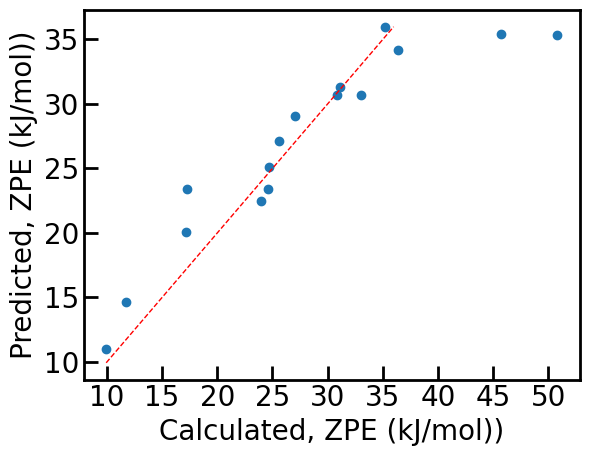

LR 0.950903003616424
RMSE:  0.22262915247534687
RMSE unscaled:  2.39368733148583
----------------------------------------


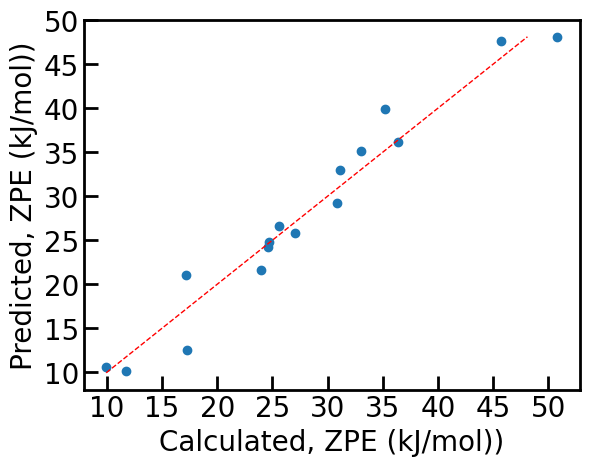

RR 0.9527563062162728
RMSE:  0.21838685494904977
RMSE unscaled:  2.348074554667594
----------------------------------------


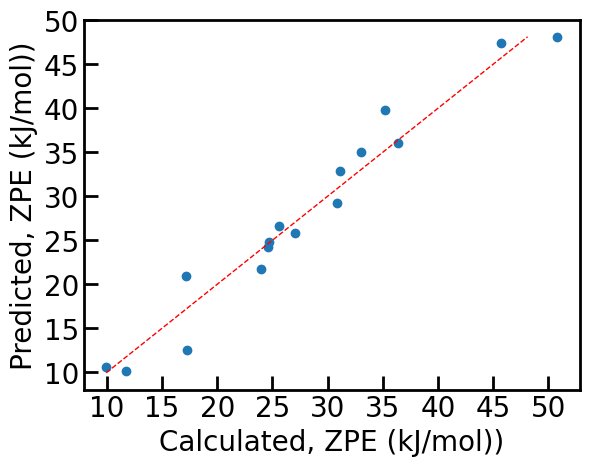

LASSO 0.9442179291860167
RMSE:  0.23730226709806124
RMSE unscaled:  2.551451255012064
----------------------------------------


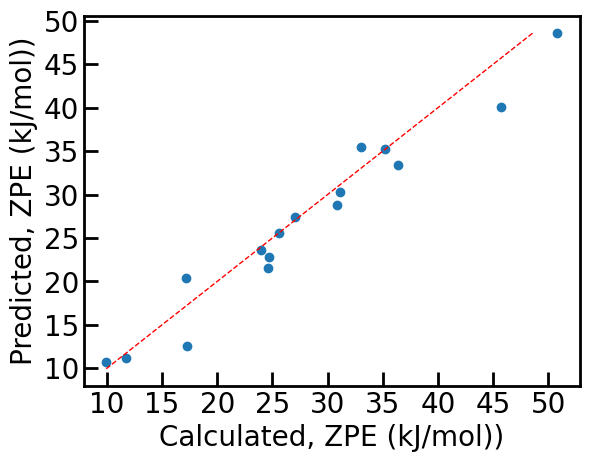

gpr1 0.9584840386519697
RMSE:  0.20472087092599367
RMSE unscaled:  2.201139202919805
----------------------------------------


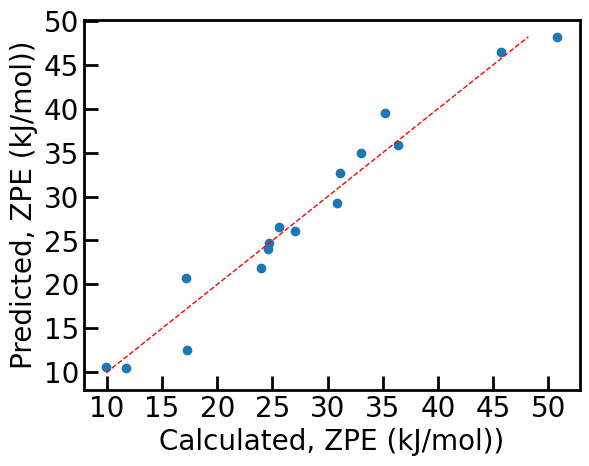

gpr2 0.9742850188446058
RMSE:  0.16111934073996897
RMSE unscaled:  1.7323397250471047
----------------------------------------


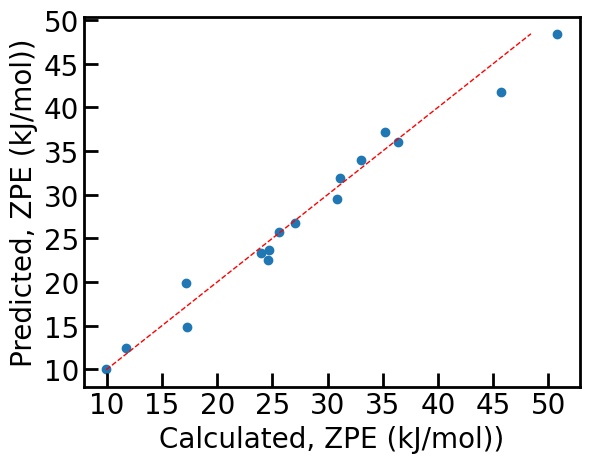

gpr3 0.9470313342279664
RMSE:  0.23124060012603778
RMSE unscaled:  2.486276792111364
----------------------------------------


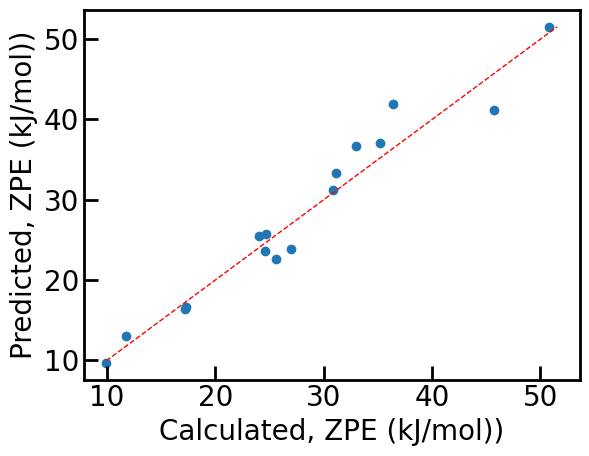

gpr4 0.9470313324512741
RMSE:  0.23124060400421154
RMSE unscaled:  2.486276833809117
----------------------------------------


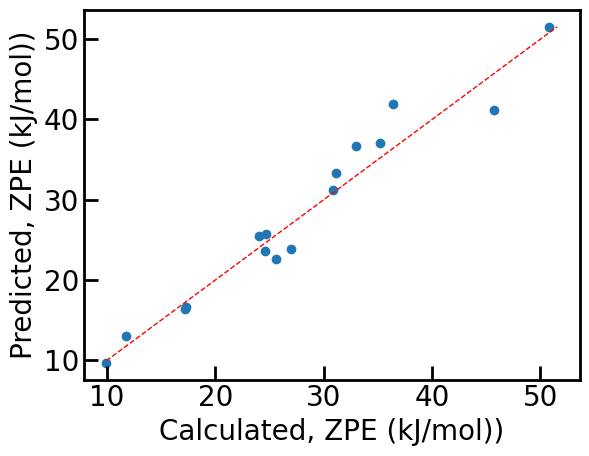

gpr5 0.9708792110870111
RMSE:  0.17145736264904932
RMSE unscaled:  1.8434931467856581
----------------------------------------


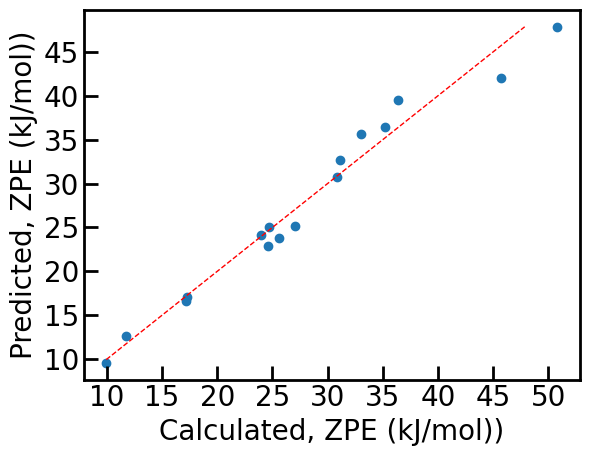

gpr6 0.8884536000962633
RMSE:  0.3355693990114496
RMSE unscaled:  3.6080100486254563
----------------------------------------


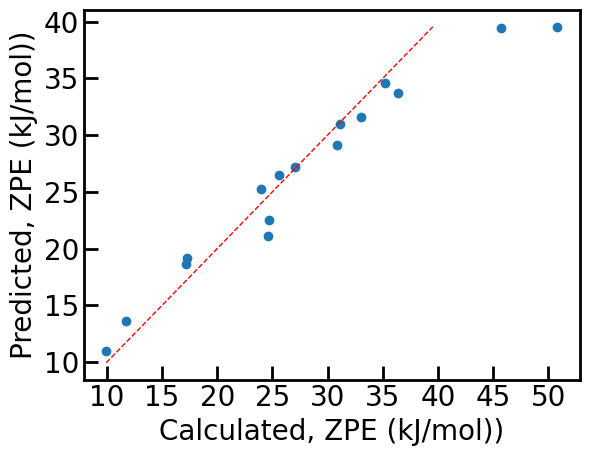

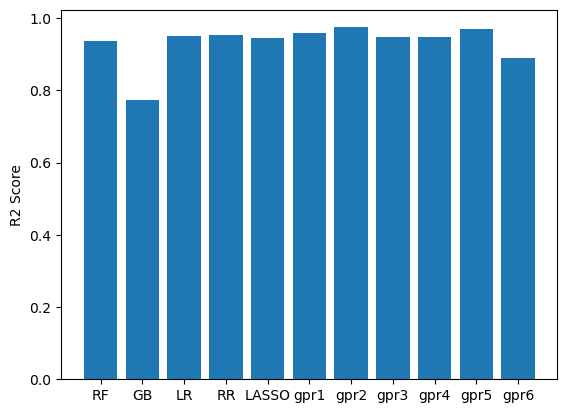

In [20]:
run_models()

In [21]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X', 'B_Ra', 'std_B2X', 'OF',
       'A_EA', 'A_ChiA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP'],
      dtype=object)

In [22]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9286949680996309
RMSE:  0.2682962856484572
RMSE unscaled:  2.8846959749017245
----------------------------------------


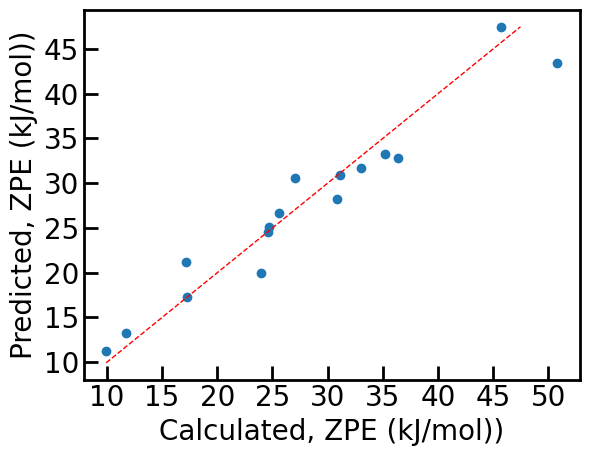

GB 0.7874976728032053
RMSE:  0.4631657280247941
RMSE unscaled:  4.979913561293962
----------------------------------------


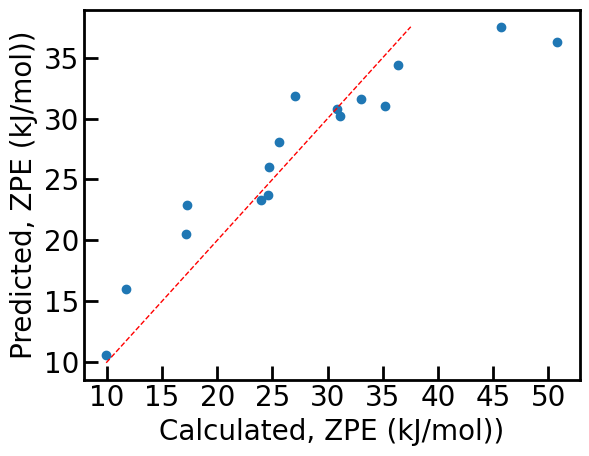

LR 0.9459506112805857
RMSE:  0.23358769668565382
RMSE unscaled:  2.511512549594424
----------------------------------------


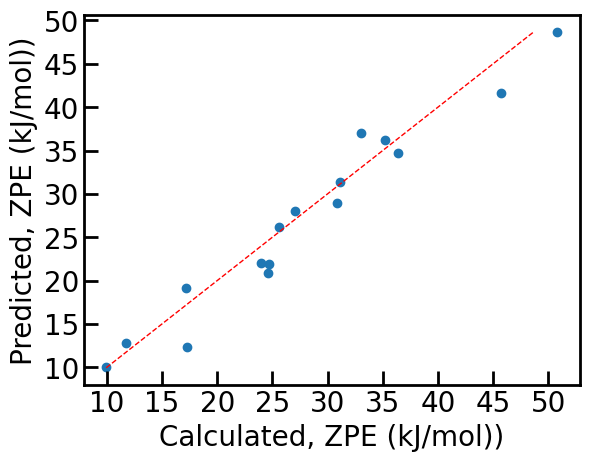

RR 0.9459422742011283
RMSE:  0.23360571135836045
RMSE unscaled:  2.511706241630526
----------------------------------------


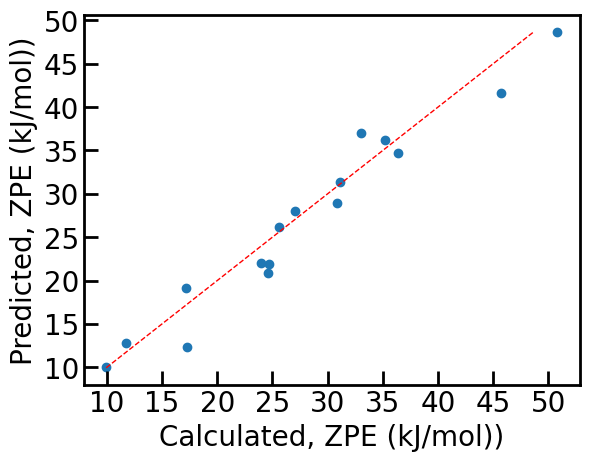

LASSO 0.9388552464645955
RMSE:  0.24844723647760444
RMSE unscaled:  2.671280898690756
----------------------------------------


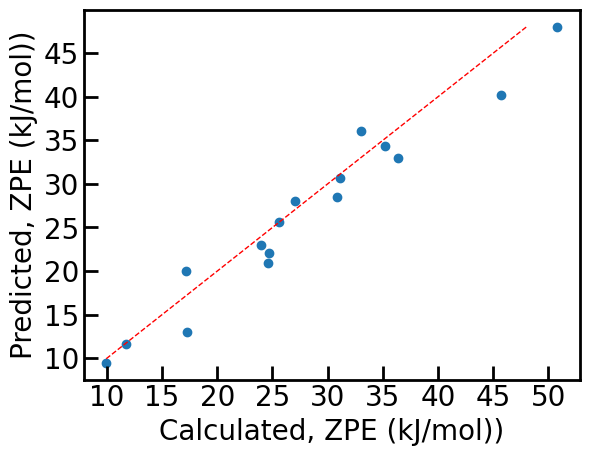

gpr1 0.9489698146634918
RMSE:  0.22696983598288323
RMSE unscaled:  2.4403579449542514
----------------------------------------


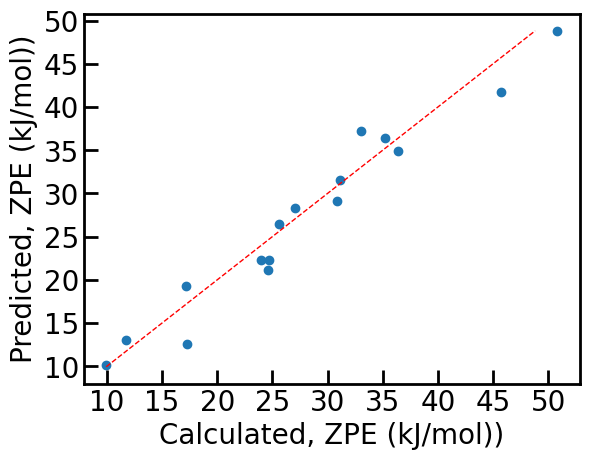

gpr2 0.9583214984845185
RMSE:  0.20512123331508061
RMSE unscaled:  2.20544386099403
----------------------------------------


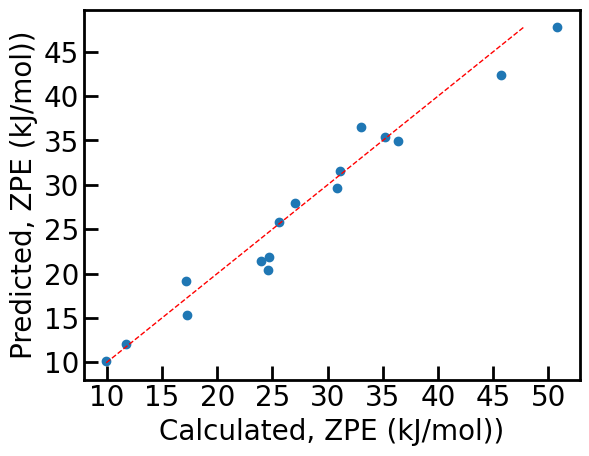

gpr3 0.946877890615354
RMSE:  0.23157529548495065
RMSE unscaled:  2.4898754045645366
----------------------------------------


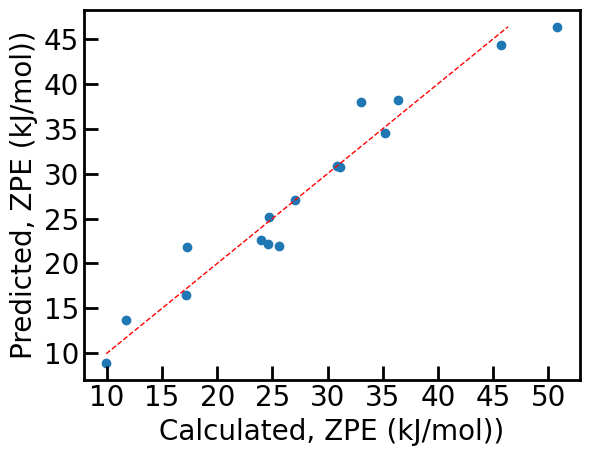

gpr4 0.9468778906061593
RMSE:  0.23157529550499176
RMSE unscaled:  2.4898754047800162
----------------------------------------


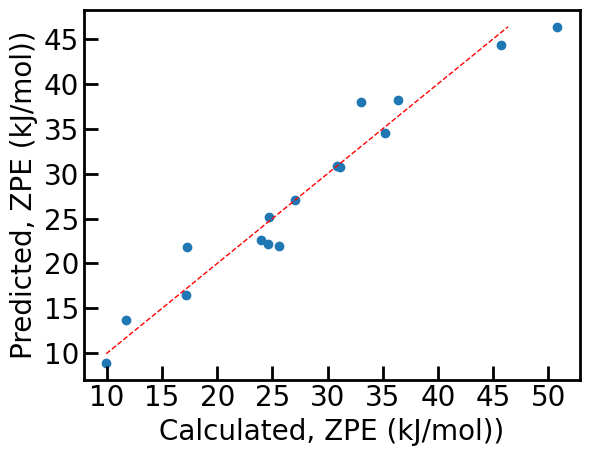

gpr5 0.965494187916835
RMSE:  0.18663826879672665
RMSE unscaled:  2.006716796169107
----------------------------------------


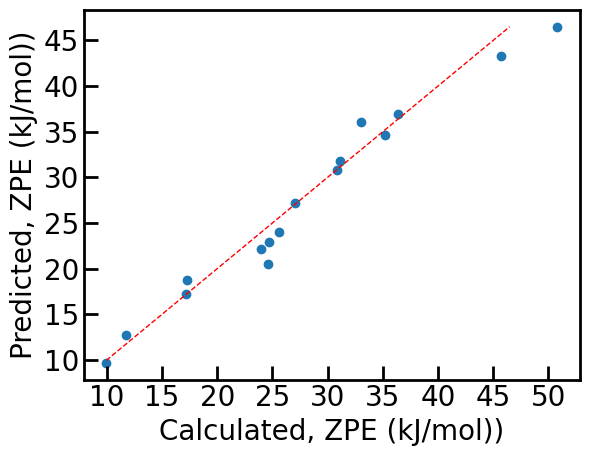

gpr6 0.9441105957729141
RMSE:  0.23753046068589456
RMSE unscaled:  2.553904770619744
----------------------------------------


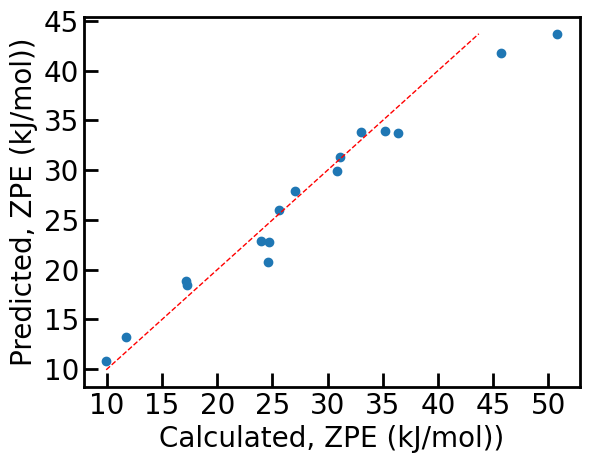

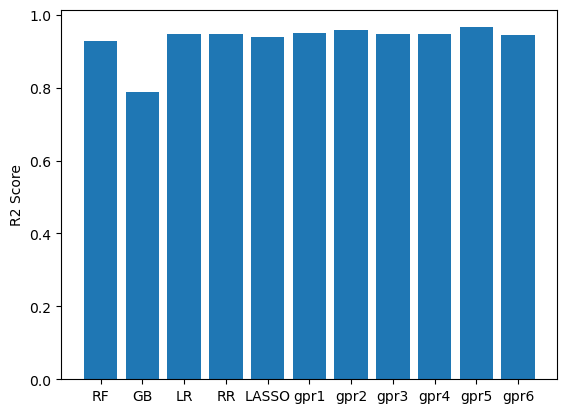

In [23]:
run_models()

In [24]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_IEI', 'B_Z', 'B_Hf'], dtype=object)

In [25]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8429023093227566
RMSE:  0.39823504120058295
RMSE unscaled:  4.281785033436411
----------------------------------------


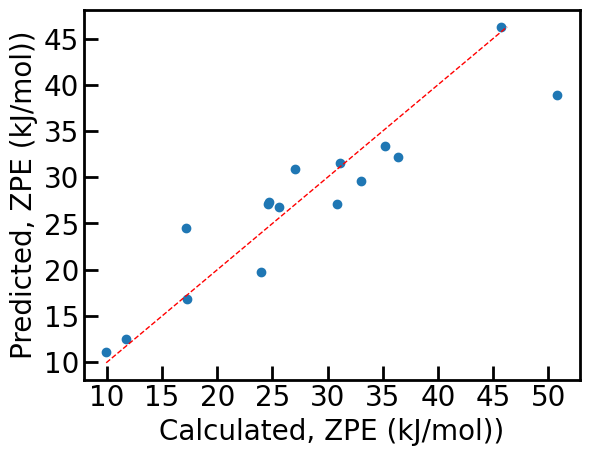

GB 0.7939525152311827
RMSE:  0.4560770613544144
RMSE unscaled:  4.90369689596801
----------------------------------------


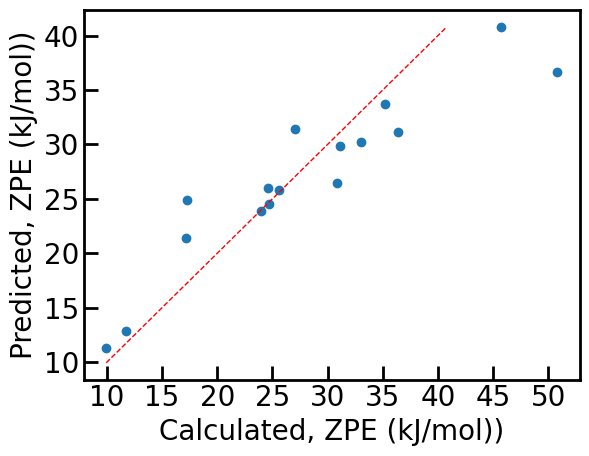

LR 0.9061984030603562
RMSE:  0.30772280821708947
RMSE unscaled:  3.3086061706139676
----------------------------------------


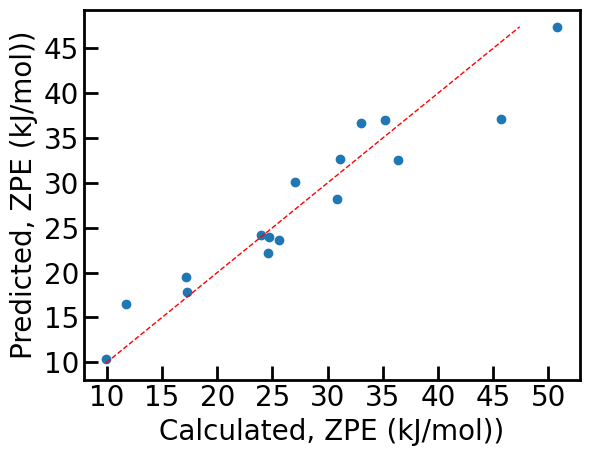

RR 0.9061931731307018
RMSE:  0.30773138667556177
RMSE unscaled:  3.3086984053781068
----------------------------------------


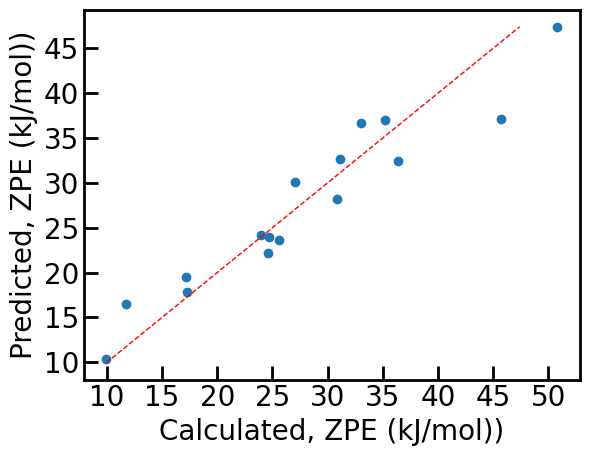

LASSO 0.9085516602490195
RMSE:  0.30383827630263377
RMSE unscaled:  3.2668400553994985
----------------------------------------


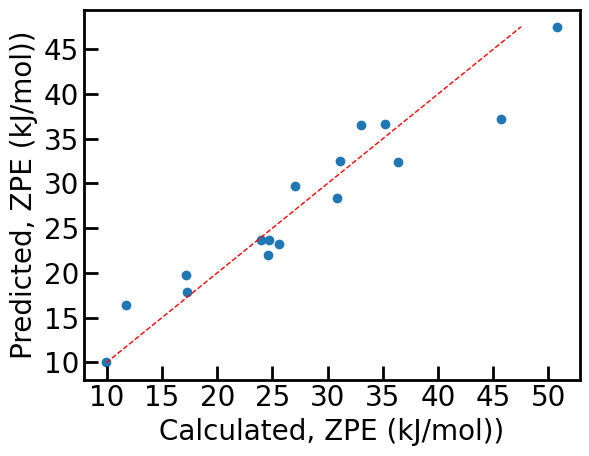

gpr1 0.90647964868445
RMSE:  0.3072611387676163
RMSE unscaled:  3.303642344896398
----------------------------------------


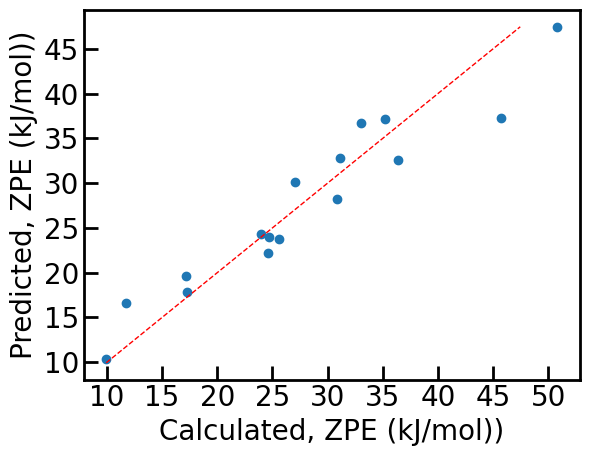

gpr2 0.920906002470708
RMSE:  0.28257018372136217
RMSE unscaled:  3.0381675603079352
----------------------------------------


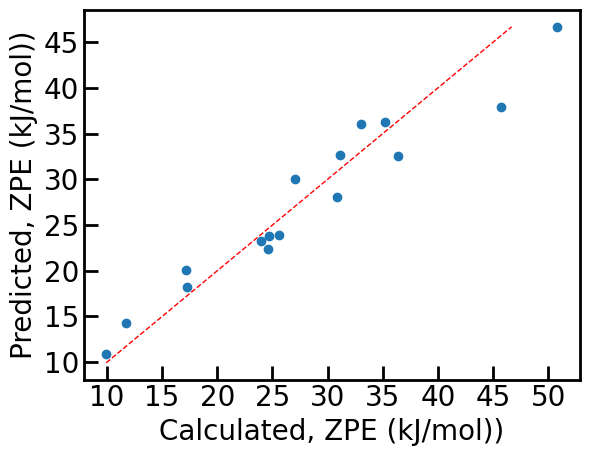

gpr3 0.9176088862194214
RMSE:  0.2883996691860914
RMSE unscaled:  3.1008456298727403
----------------------------------------


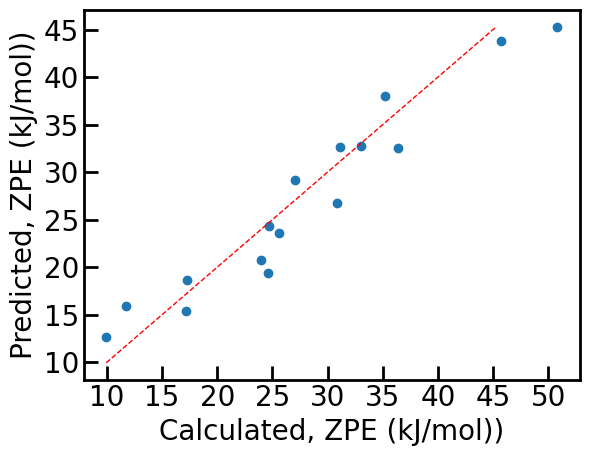

gpr4 0.9176088806391464
RMSE:  0.2883996789526144
RMSE unscaled:  3.10084573488146
----------------------------------------


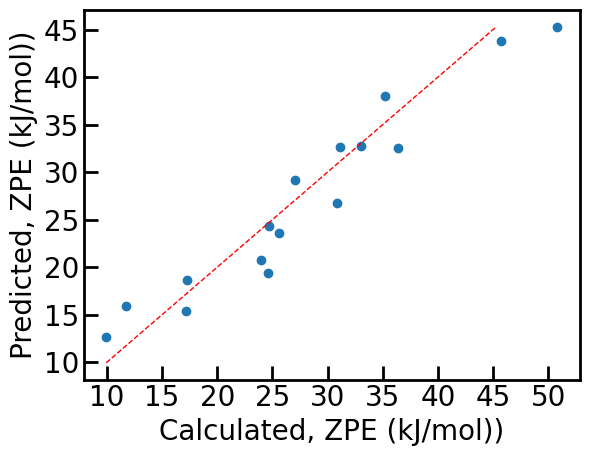

gpr5 0.9453419377013415
RMSE:  0.23489928056334028
RMSE unscaled:  2.5256145738679376
----------------------------------------


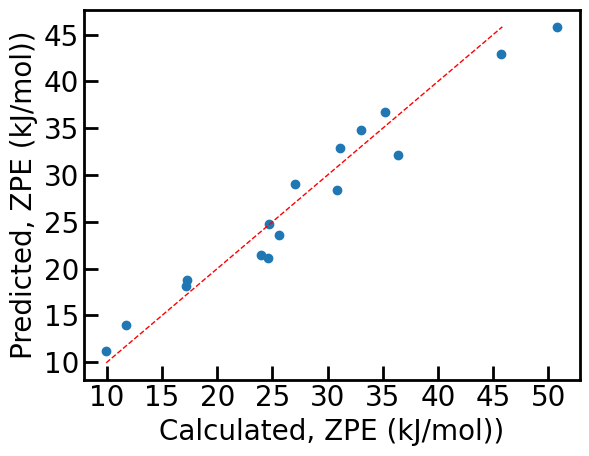

gpr6 0.9356087916839885
RMSE:  0.25495753898462586
RMSE unscaled:  2.7412790479085376
----------------------------------------


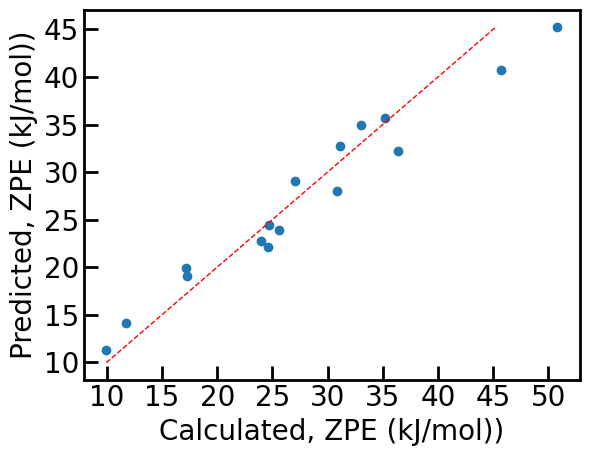

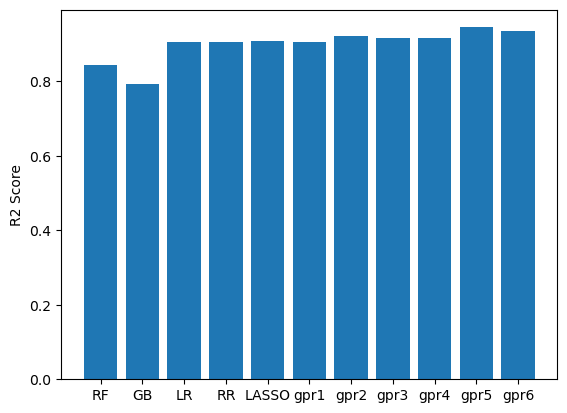

In [26]:
run_models()

# Min-Max scaling

In [27]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data['Coef_d']).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data['Coef_d']).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std['Coef_d'] 
X = data_std.drop(['Coef_d'], axis=1)

In [28]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [29]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'X_M', 'A_BP', 'X_B', 'X_Ra', 'X_MP', 'X_Rc', 'X_CvM', 'A_M', 'A_MendeleevNo', 'A_Rc', 'A_Ra', 'B_M', 'A_Hf', 'X_Hv', 'B_Hv', 'X_IEII', 'X_MendeleevNo', 'X_ChiA', 'X_Hf', 'A_MV', 'X_BP', 'B_BP', 'A_Hv'}


In [30]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape
#data_std.to_csv('scaled_non_corr_all.csv',index=False)

(80, 51)

In [31]:
print(correlated_features)

{'X_M', 'A_BP', 'X_B', 'X_Ra', 'X_MP', 'X_Rc', 'X_CvM', 'A_M', 'A_MendeleevNo', 'A_Rc', 'A_Ra', 'B_M', 'A_Hf', 'X_Hv', 'B_Hv', 'X_IEII', 'X_MendeleevNo', 'X_ChiA', 'X_Hf', 'A_MV', 'X_BP', 'B_BP', 'A_Hv'}


### Test-train splitting 

In [32]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('Coef_d')
X = df_train

Y_test = df_test.pop('Coef_d')
X_test = df_test

RF 0.9366643460293314
RMSE:  0.05853511177239015
RMSE unscaled:  2.718717538817344
----------------------------------------


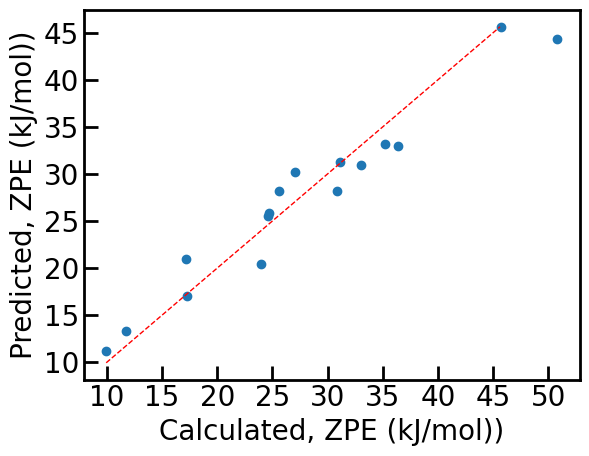

GB 0.8451735443229044
RMSE:  0.09151976753890782
RMSE unscaled:  4.250720458585965
----------------------------------------


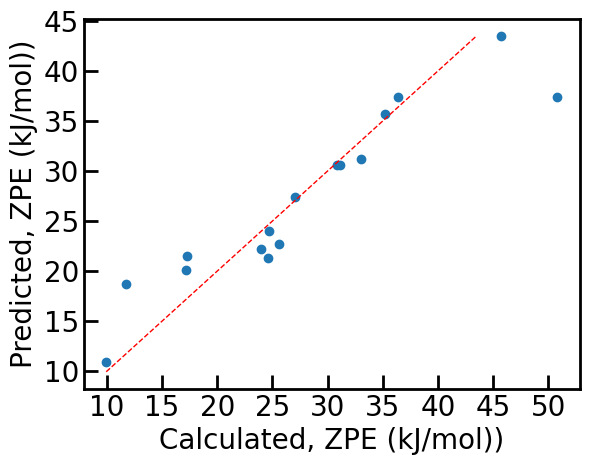

LR 0.9524950998043127
RMSE:  0.05069457977352297
RMSE unscaled:  2.3545567605503543
----------------------------------------


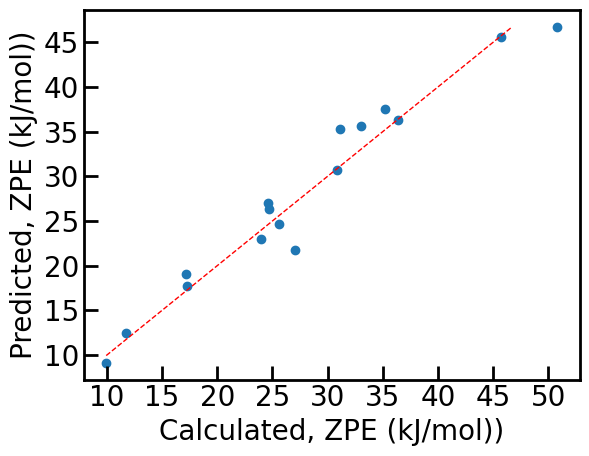

RR 0.9638312784127314
RMSE:  0.0442342737844532
RMSE unscaled:  2.0545018590255038
----------------------------------------


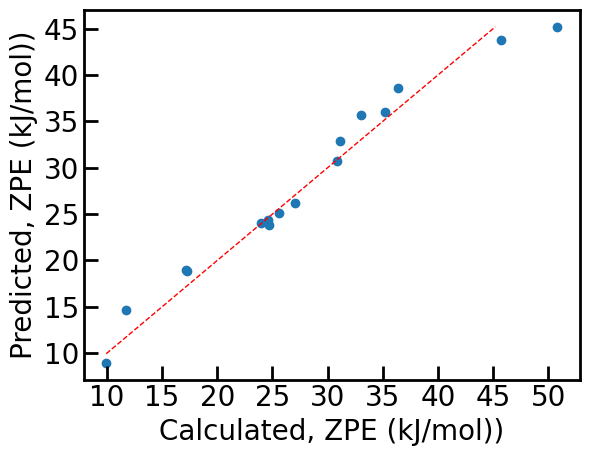

LASSO 0.7850145992867488
RMSE:  0.10784420337370988
RMSE unscaled:  5.008924016613653
----------------------------------------


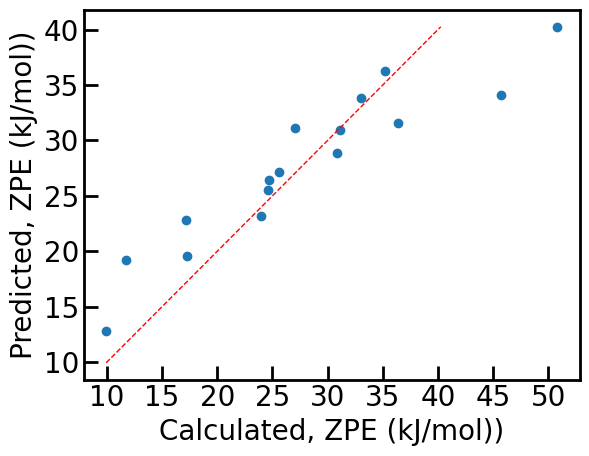

gpr1 0.9625620601649902
RMSE:  0.04500370750405198
RMSE unscaled:  2.090238921535348
----------------------------------------


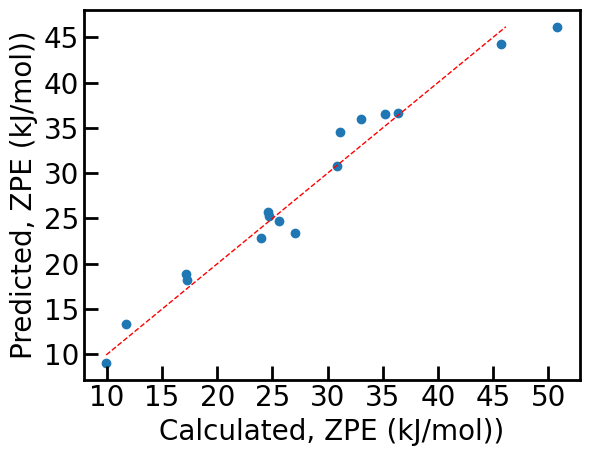

gpr2 0.955958725407646
RMSE:  0.048811512150506824
RMSE unscaled:  2.2670959388578966
----------------------------------------


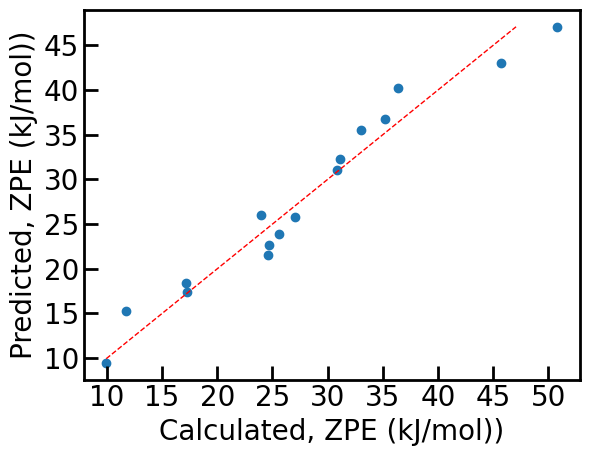

gpr3 0.90707508563737
RMSE:  0.07090198713936076
RMSE unscaled:  3.2931085315481368
----------------------------------------


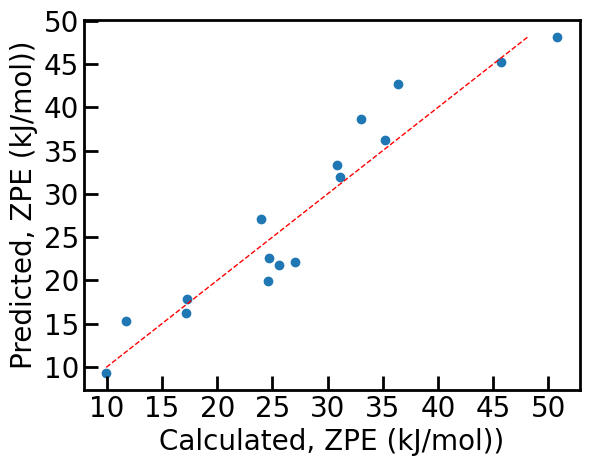

gpr4 0.9070750535715557
RMSE:  0.07090199937251575
RMSE unscaled:  3.293109099728363
----------------------------------------


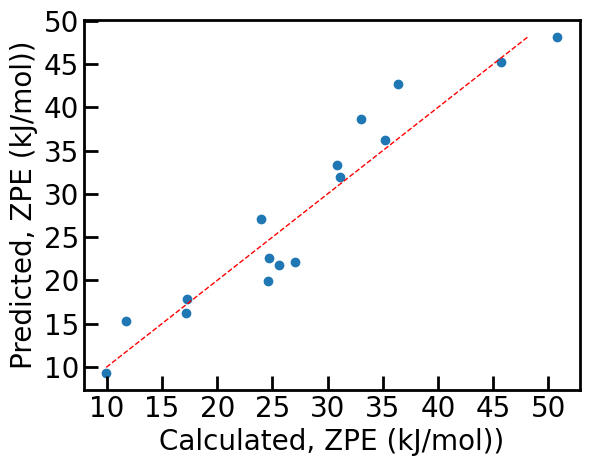

gpr5 0.9444882423060197
RMSE:  0.05480053669024074
RMSE unscaled:  2.545261736505902
----------------------------------------


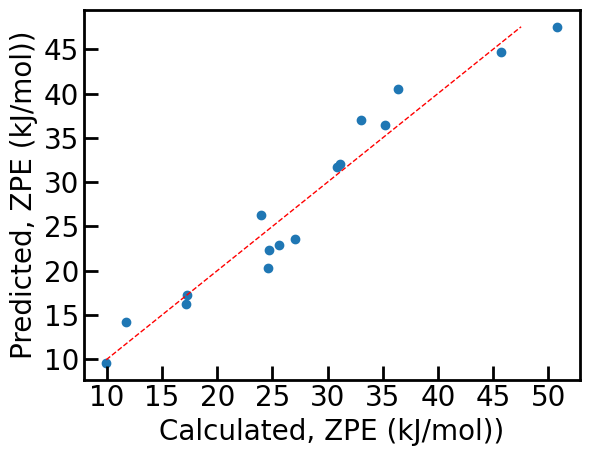

gpr6 0.8977293922808167
RMSE:  0.07438198100743462
RMSE unscaled:  3.454740073329389
----------------------------------------


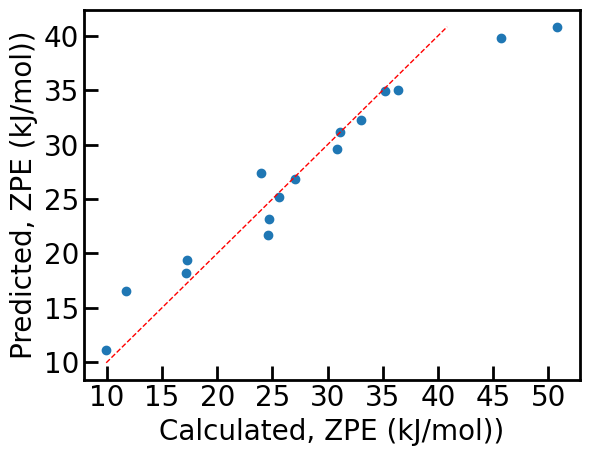

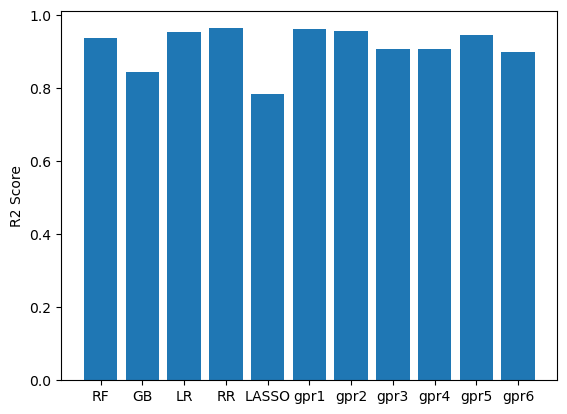

In [33]:
run_models()

## Feature selection


In [34]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
25      X_EA  81.232938
32    X_Rvdw  69.112112
14       X_Z  43.753926
1   mean_A2B  36.476139
17       X_G  32.133586
4   mean_X2X  21.756733
30    A_Rvdw  21.351495
18     A_IEI  18.448048
13       B_Z  16.733902
41      B_Hf  16.431242
2   mean_A2X  14.661730
34      B_Ra  14.611618
7    std_B2X  14.051080
11        OF  12.789702
23      A_EA  12.359494
29    A_ChiA  12.090829
6    std_A2X  10.602250
38     B_Rho   9.731500
9      E_coh   9.463266
26    A_ChiP   9.223658
46     B_CvM   8.515155
36      B_MP   8.146515
33      B_Rc   7.662039
10        TF   6.853180
31    B_Rvdw   6.627869
35      A_MP   5.800927
8    std_X2X   5.596058
42   A_Kappa   5.555247
40      X_MV   5.384953
5    std_A2B   5.191784


In [35]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X', 'B_Ra', 'std_B2X', 'OF',
       'A_EA', 'A_ChiA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP', 'B_CvM',
       'B_MP', 'B_Rc', 'TF', 'B_Rvdw', 'A_MP', 'std_X2X', 'A_Kappa',
       'X_MV', 'std_A2B'], dtype=object)

In [36]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9341085838453743
RMSE:  0.05970445566672282
RMSE unscaled:  2.773028800181173
----------------------------------------


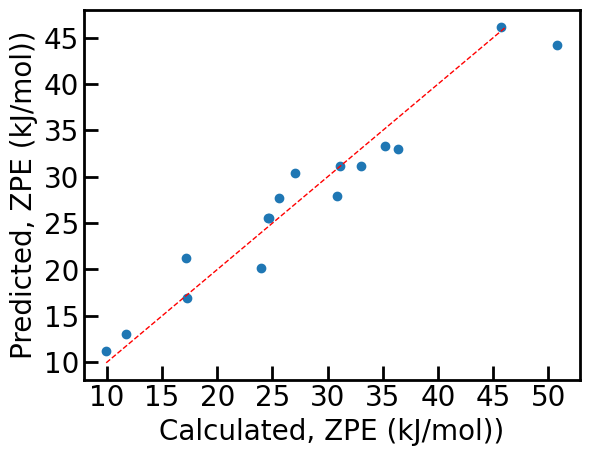

GB 0.7731895759533598
RMSE:  0.1107704264395385
RMSE unscaled:  5.1448351600397535
----------------------------------------


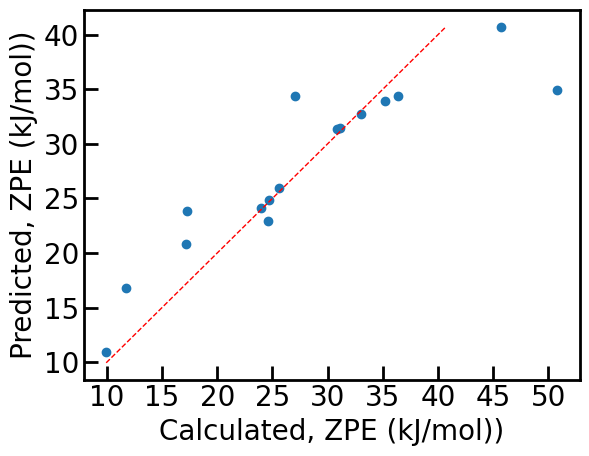

LR 0.9509030036164238
RMSE:  0.05153707713145821
RMSE unscaled:  2.3936873314858356
----------------------------------------


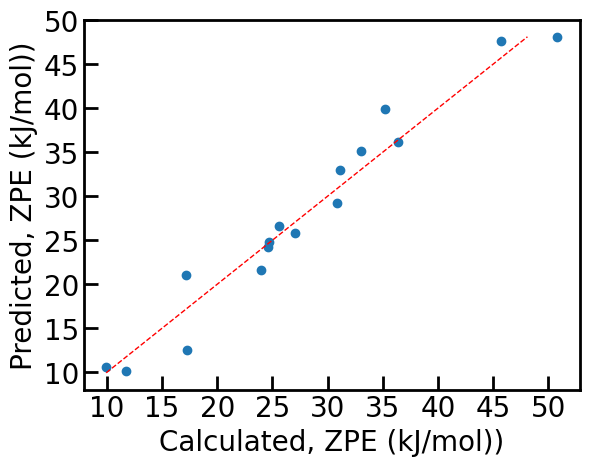

RR 0.9653844258472573
RMSE:  0.043274104759359396
RMSE unscaled:  2.009905918406099
----------------------------------------


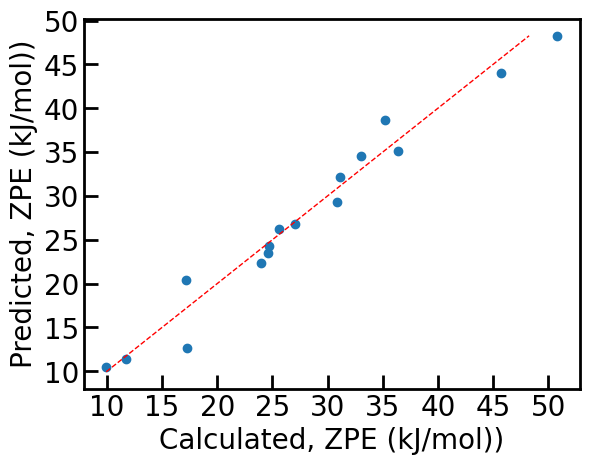

LASSO 0.7849982273604044
RMSE:  0.10784830966124191
RMSE unscaled:  5.009114736945344
----------------------------------------


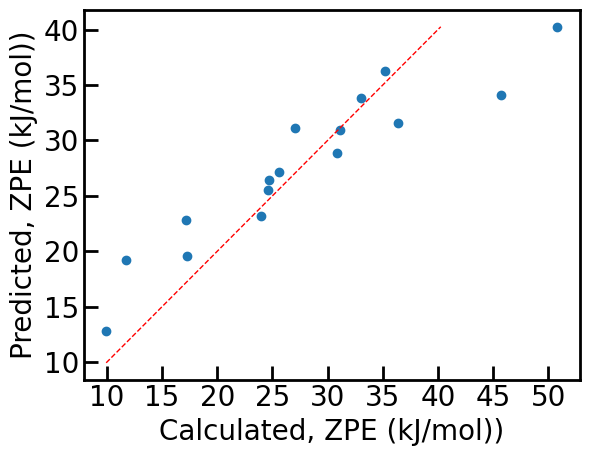

gpr1 0.9636954714520083
RMSE:  0.04431724179494665
RMSE unscaled:  2.0583553851990994
----------------------------------------


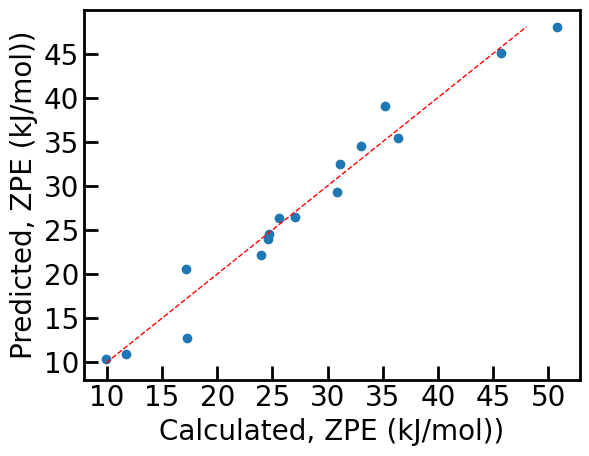

gpr2 0.9654331930738772
RMSE:  0.04324361123253401
RMSE unscaled:  2.0084896182797243
----------------------------------------


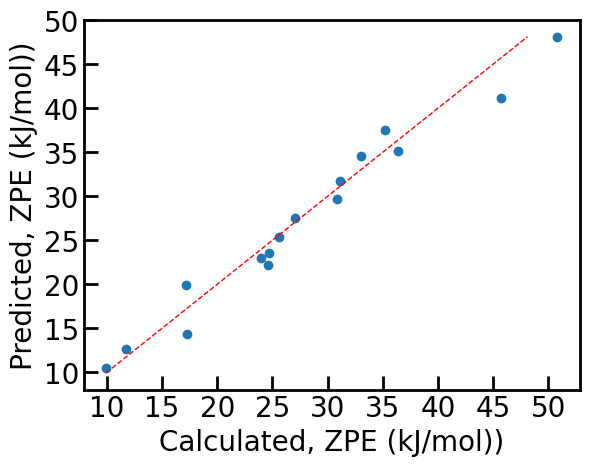

gpr3 0.9325268163754972
RMSE:  0.06041682844947041
RMSE unscaled:  2.8061156145732404
----------------------------------------


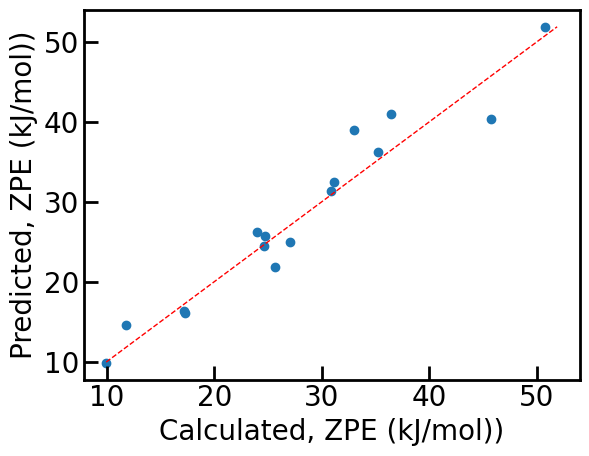

gpr4 0.9325268079659995
RMSE:  0.060416832214485905
RMSE unscaled:  2.8061157894428757
----------------------------------------


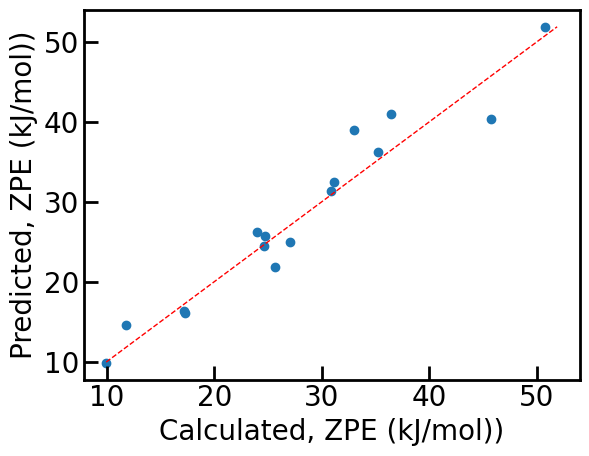

gpr5 0.9717850708844489
RMSE:  0.03906895581696741
RMSE unscaled:  1.8145938768493106
----------------------------------------


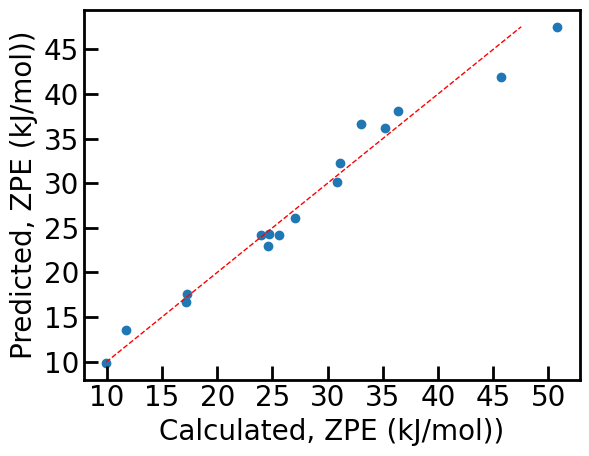

gpr6 0.9192813924744353
RMSE:  0.06608138746945029
RMSE unscaled:  3.0692113103185292
----------------------------------------


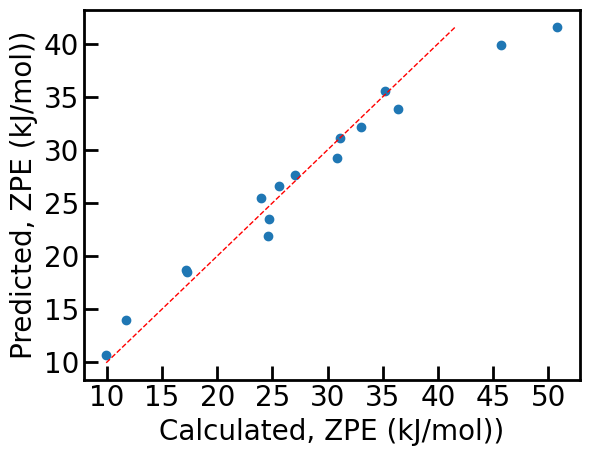

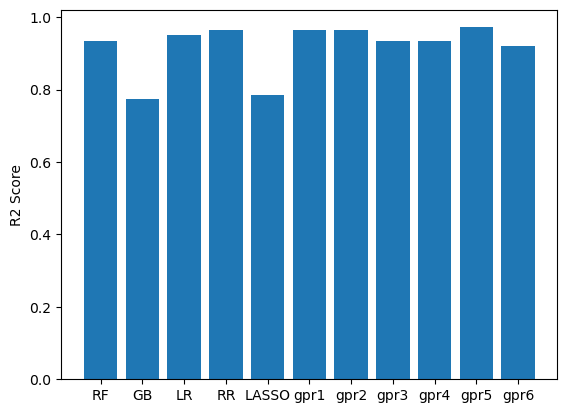

In [37]:
run_models()

In [38]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X', 'B_Ra', 'std_B2X', 'OF',
       'A_EA', 'A_ChiA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP'],
      dtype=object)

In [39]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9226043352108173
RMSE:  0.06470690683248563
RMSE unscaled:  3.0053722827446014
----------------------------------------


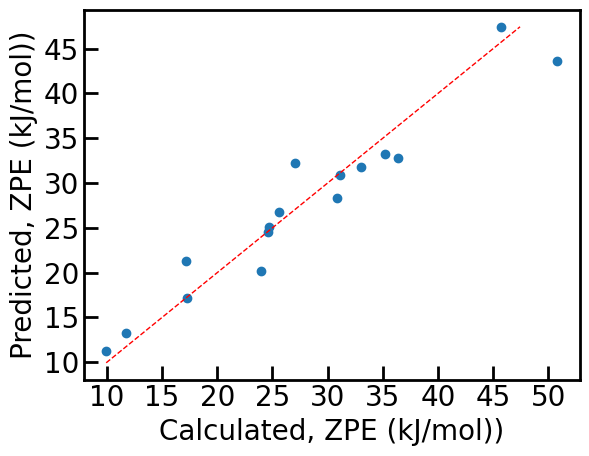

GB 0.748171243957638
RMSE:  0.11671992033665038
RMSE unscaled:  5.421164920339182
----------------------------------------


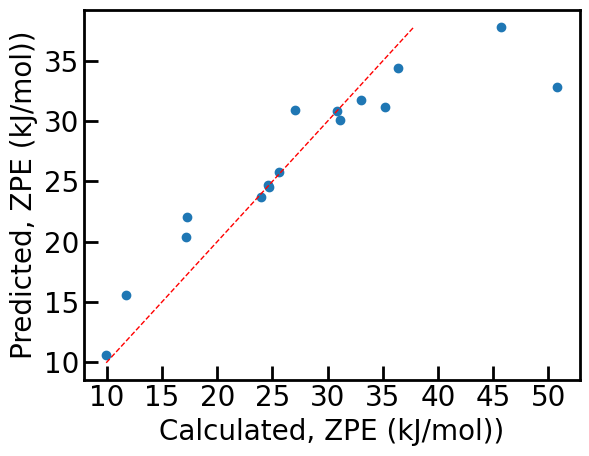

LR 0.9459506112805858
RMSE:  0.05407390275350958
RMSE unscaled:  2.5115125495944204
----------------------------------------


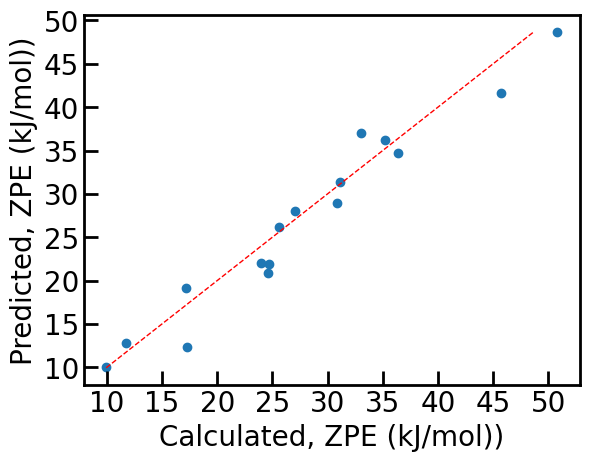

RR 0.945629547125183
RMSE:  0.0542342698398369
RMSE unscaled:  2.5189609476079484
----------------------------------------


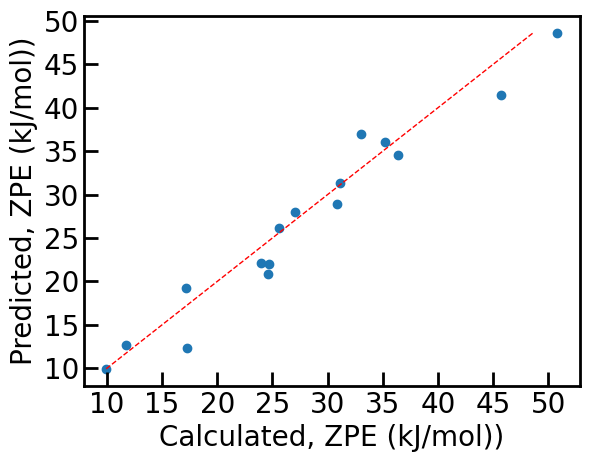

LASSO 0.7849979340933367
RMSE:  0.1078483832149302
RMSE unscaled:  5.009118153214594
----------------------------------------


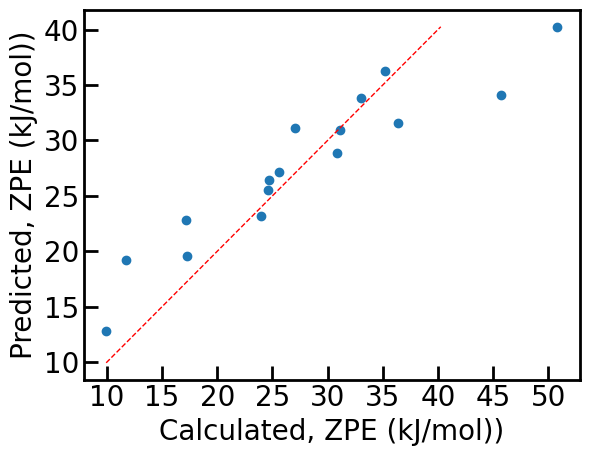

gpr1 0.9454950162063605
RMSE:  0.05430132536387378
RMSE unscaled:  2.522075403594341
----------------------------------------


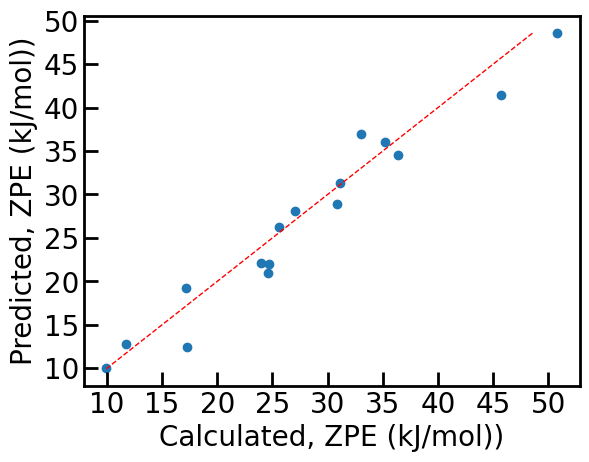

gpr2 0.9525801845501936
RMSE:  0.050649160579649834
RMSE unscaled:  2.3524472239791767
----------------------------------------


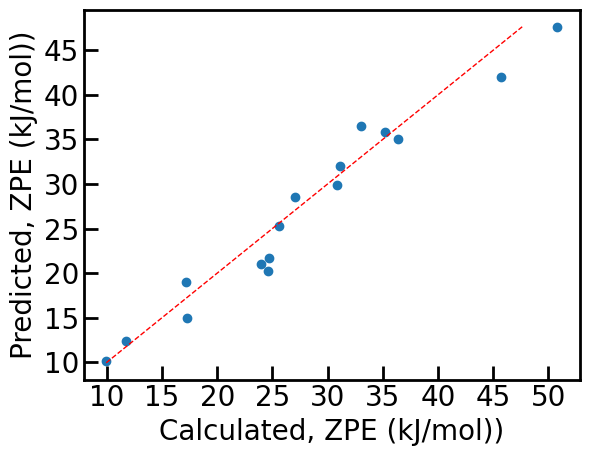

gpr3 0.9231229133161929
RMSE:  0.06448976299832963
RMSE unscaled:  2.995286836035939
----------------------------------------


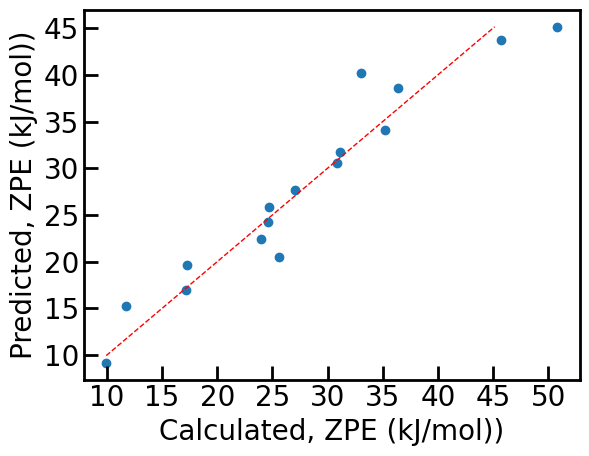

gpr4 0.9231229043629551
RMSE:  0.06448976675362394
RMSE unscaled:  2.995287010454065
----------------------------------------


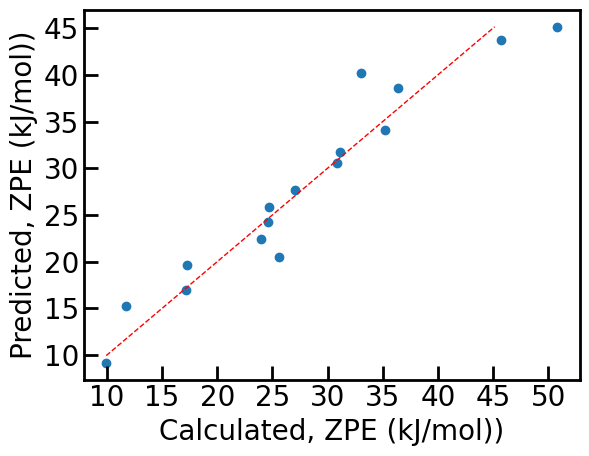

gpr5 0.9622502447662522
RMSE:  0.04519073369595639
RMSE unscaled:  2.0989255264251767
----------------------------------------


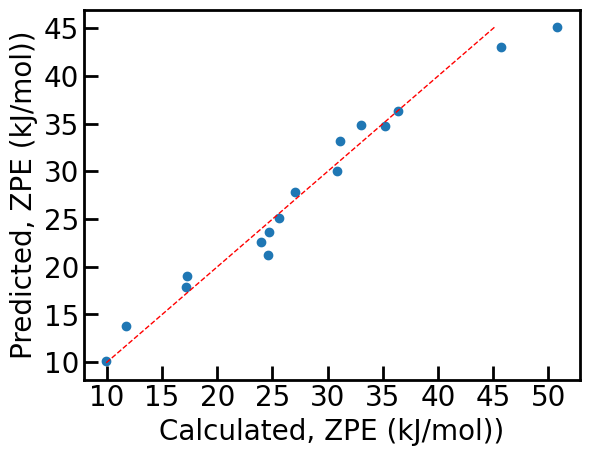

gpr6 0.9439572149996056
RMSE:  0.055062024699338304
RMSE unscaled:  2.55740678953473
----------------------------------------


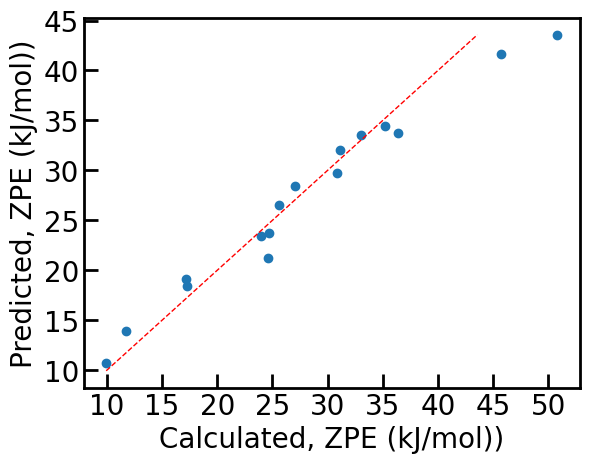

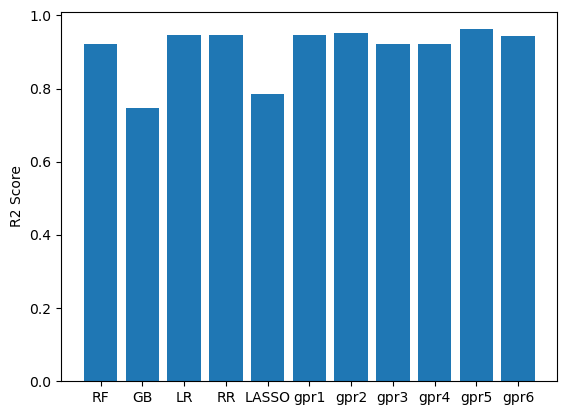

In [40]:
run_models()

In [41]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_IEI', 'B_Z', 'B_Hf'], dtype=object)

In [42]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.7969735720506055
RMSE:  0.10480176799756669
RMSE unscaled:  4.867615284685335
----------------------------------------


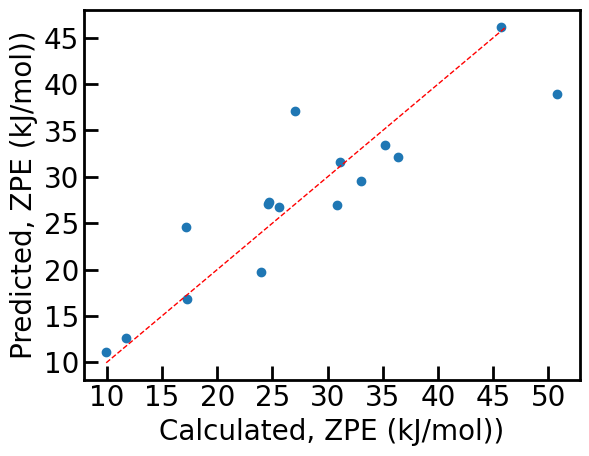

GB 0.7914432185815797
RMSE:  0.10621955565645204
RMSE unscaled:  4.93346574704575
----------------------------------------


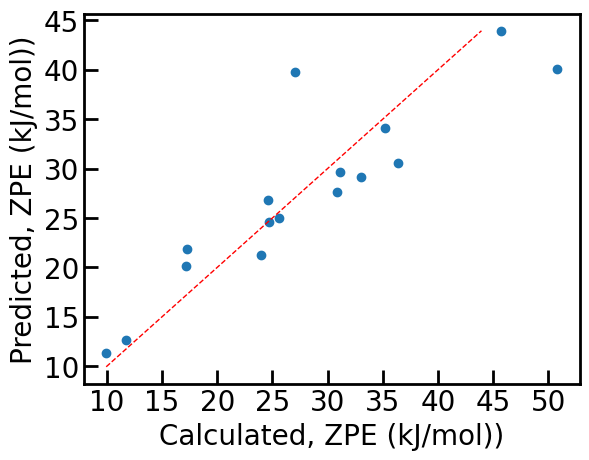

LR 0.9061984030603563
RMSE:  0.07123565771086153
RMSE unscaled:  3.308606170613965
----------------------------------------


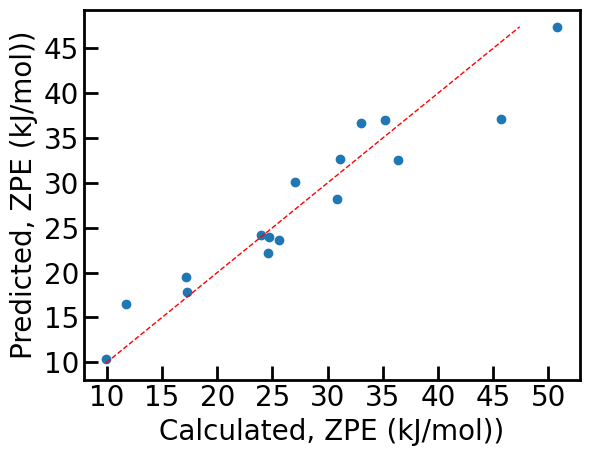

RR 0.9061792863979504
RMSE:  0.07124291621545255
RMSE unscaled:  3.308943298589632
----------------------------------------


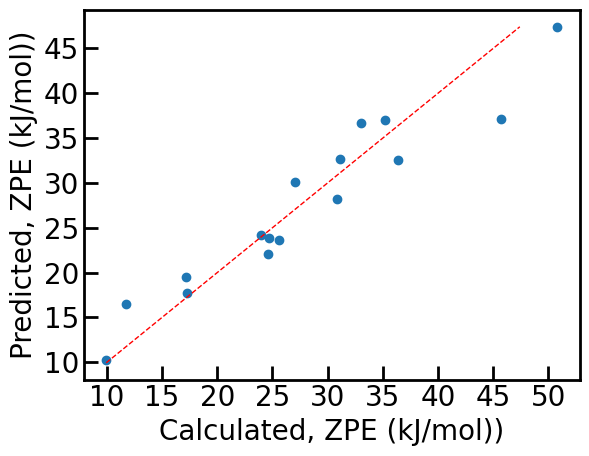

LASSO 0.7857255407104542
RMSE:  0.10766573915575207
RMSE unscaled:  5.00063508054226
----------------------------------------


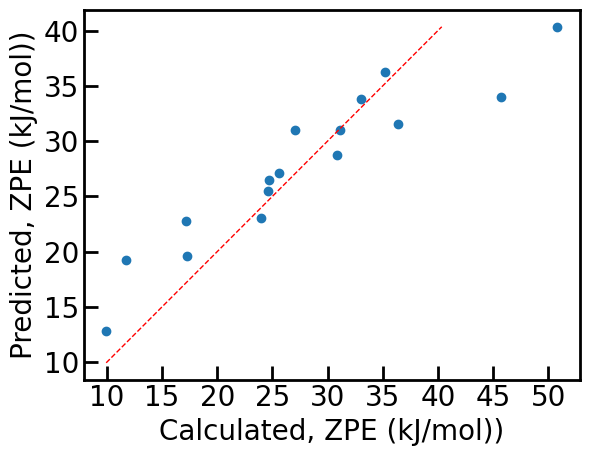

gpr1 0.9057833592914963
RMSE:  0.07139308191209075
RMSE unscaled:  3.315917883600529
----------------------------------------


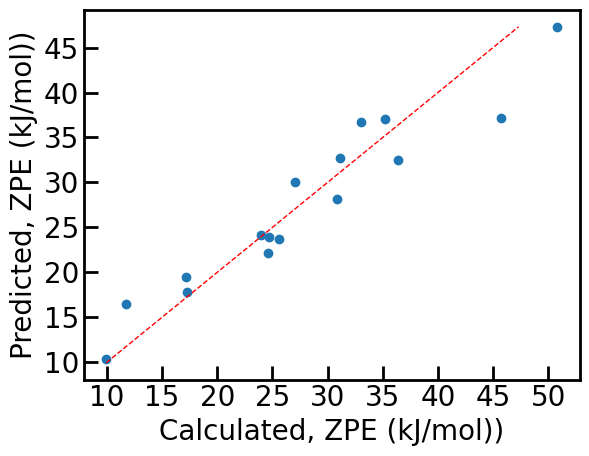

gpr2 0.9221758469681733
RMSE:  0.0648857791209382
RMSE unscaled:  3.0136801720284776
----------------------------------------


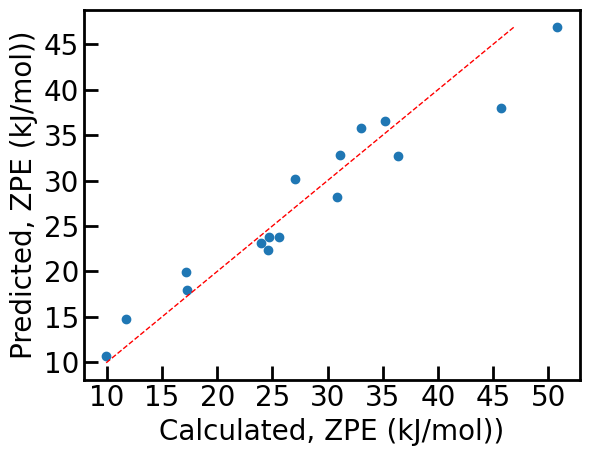

gpr3 0.8375628209661039
RMSE:  0.09374217844281976
RMSE unscaled:  4.35394239359172
----------------------------------------


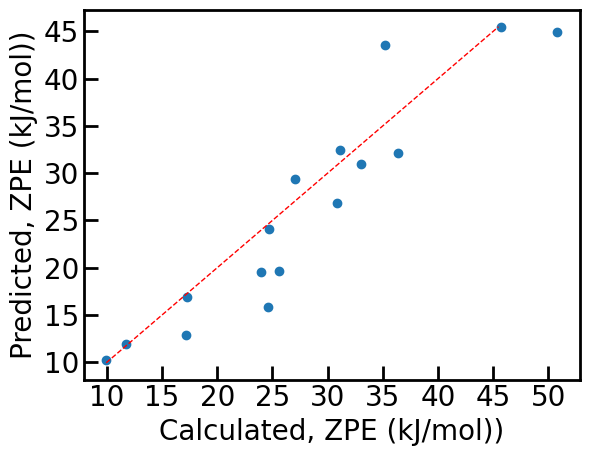

gpr4 0.8375628156233376
RMSE:  0.09374217998446974
RMSE unscaled:  4.353942465195083
----------------------------------------


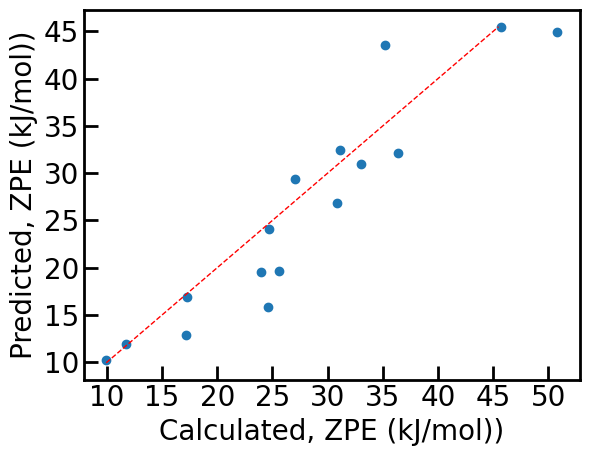

gpr5 0.928813285696309
RMSE:  0.06205714569344292
RMSE unscaled:  2.88230166983787
----------------------------------------


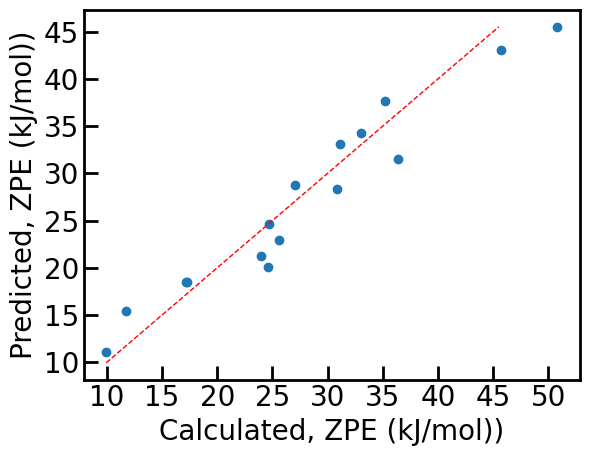

gpr6 0.9300473898989423
RMSE:  0.06151687763843887
RMSE unscaled:  2.8572084190978067
----------------------------------------


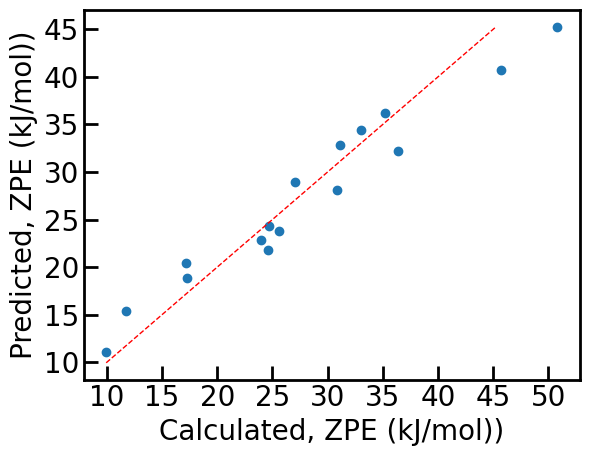

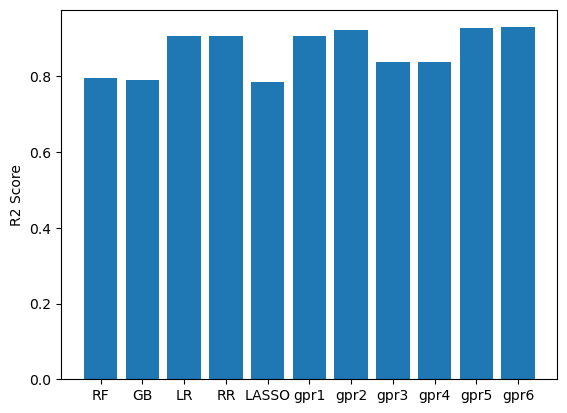

In [43]:
run_models()